I recently found an analysis of techno music using principal component analysis (PCA).

https://www.math.uci.edu/~isik/posts/Eigentechno.html

The author, Umut Isik, extracted more than 90,000 clips of one bar worth of music from 10,000 different techno music tracks and stretched the music to all have the same tempo of 128 bpm. Then Isik fed those tracks through PCA and then analyzed the resulting principal vectors and the quality of music approximation with a growing number of components. Since the principal vectors are modeling sound we can listen to them which is rather fun. I won't cover all the same material as Isik did in that post and it is worth a read so nip over and give it a look if you haven't already. Isik has very kindly bundled up the source data and made it available for others to use (theres a link at the end of the post linked above). Playing around with such a fun data set is too tempting to resist so I'm going to do my own "eigentechno" analysis here.

<!-- TEASER_END -->


# Raw Loops PCA

First we will carry out an analysis similar to the first one carried out in the original eigentechno post before making some adjustments which hopefully will improve the results. We will use the 8820 Hz sampled loops in the hdf5 file. 

In [1]:
import os
import numpy as np
np.random.seed(1234)

import pandas as pd
import scipy.ndimage
import scipy.signal
import sklearn.covariance
import sklearn.decomposition
import h5py
import scipy.io.wavfile


import IPython.display as ipd
import matplotlib.pyplot as plt

/home/tim/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline

from matplotlib.colors import LinearSegmentedColormap
clist = [(0.0, 0.5, 1.0), (0.0, 0.0, 0.0), (1.0, 0.5, 0.0)]
blue_orange_divergent = LinearSegmentedColormap.from_list("BuOrDiv", clist)

plt.rcParams.update(
    {
        "figure.figsize":(12, 6),
        "font.size":15,
        "image.cmap":"viridis",
        "image.aspect":"auto",
        "lines.linewidth":2,
    }
)

First we subtract off the mean of each sound clip and normalize them to all have the same norm. It would probably be better to normalize the sound clips in some way related to human hearing so that they all have the same appparent loudness but lets keep it simple for now.

In [3]:
hf = h5py.File("/home/tim/Downloads/technoset-share/loops_8820hz.h5")

#normalize and mean center
#loops = np.array(hf["loops"][:2000])
loops = np.array(hf["loops"])
loops = (loops - np.mean(loops, axis=1).reshape((-1, 1)))/np.std(loops, axis=1).reshape((-1, 1))

hf.close()

Instead of keeping all 16,000 principal components as Isik did we will just keep the first several hundred components. This means that we will lose the ability to do perfect reconstruction of the audio clips from the principal component values but it lowers the computational requirements of the analysis significantly.

In [4]:
n_components = 500

pca_raw = sklearn.decomposition.PCA(n_components=n_components).fit(loops)

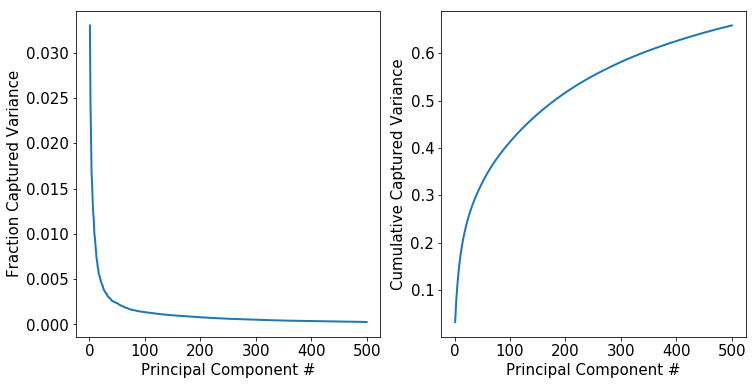

In [5]:
fig, axes = plt.subplots(1, 2)
pc_num = np.arange(1, n_components+1)
axes[0].plot(pc_num, pca_raw.explained_variance_ratio_)
axes[1].plot(pc_num, np.cumsum(pca_raw.explained_variance_ratio_))
axes[0].set_xlabel("Principal Component #")
axes[1].set_xlabel("Principal Component #")
axes[0].set_ylabel("Fraction Captured Variance")
axes[1].set_ylabel("Cumulative Captured Variance");

As we can see the first few principal components capture a lot more structure than the later ones. But the most informative eigenvector accounts for only about 3% of the total observed data variance and when we sum up the cumulative effect of the eigenvectors we can see that even the first 500 eigenvectors are sufficient to capture only a little less than 70% of the data variance. Lets compare the input audio of some of the loops and its sound after approximation via the first 500 components. Here are the originals,

In [6]:
def save_and_play(
    fname, 
    arr,
    clip_percentile=99.9,
    rate=8820,
    target_dir="../sounds",
):
    if len(arr.shape) == 2:
        arr = np.hstack(list(arr))
    
    max_val = np.percentile(arr, clip_percentile)
    arr = ((2**15-10)*np.clip(arr/max_val, -1, 1)).astype(np.int16)
    
    fpath = os.path.join(target_dir, fname)
    scipy.io.wavfile.write(fpath, rate=rate, data=arr)
    return ipd.Audio(url=fpath)

In [7]:
save_and_play("example_loops.wav", loops[:10])

and here are the PCA approximations

In [8]:
reconstruction_l0 = pca_raw.inverse_transform(pca_raw.transform(loops[:10]))
save_and_play("example_loops_pca_approx.wav", reconstruction_l0)


While being pleasant to listen to I wouldn't say that the PCA approximation has really captured much of the original music. The beat structure is similar but nearly all of the higher frequency information has been lost and if you scrambled the PCA approximations and asked me to identify which one corresponded to which original loop I doubt I could do much better than random guessing.

# The trouble with phase cancellation. 

It is helpful to model sound as being a sum of sine waves with different magnitudes and phase offsets. Using the inestimably helpful Fast Fourier Transform (FFT) we can express any (discretely sampled) signal $y(t)$ as a sum of the form,

$$
y(t) = \sum A_i e^{-i(\omega_i t + \phi_i)} = \sum A_i e^{-i \phi_i} e^{-i \omega_i t}
$$

The magnitudes $A_i$ may be thought of as the volume in our sample of the frequency $\omega_i$ and the phases $e^{-i \phi_i}$ represent slight shifts of each wave in time. Changes in the $A_i$ will in general tend to be audible as differences in the loudness of different pitches. In contrast changes in the phases $\phi$ will tend to be inaudible since they represent shifts in time on the order of 0.001 seconds or so (dependent on the frequency being considered). There are many exceptions to this rule, (more on this soon) but in general, the volume at a particular frequency as encoded by the $A_i$, is much much more important in terms of human hearing than the associated phases. 

PCA seeks out variance no matter how it arises be it noise or otherwise. To a rough approximation it is sensible to think of the phases $\phi_i$ as being randomly uniformly distributed over $[-\pi, \pi]$ but as being otherwise structureless. This random distribution of phases creates a huge source of variance in our data dominating over the effects of variations in the $A_i$ magnitudes. Because the phases enter in multiplicatively via $e^{-i \phi_i}A_i$ they control whether the volume of a given frequency component will tend to add to the sound intensity at a given point in time or take away from it. Changes in phase generate a lot of variance and there is a lot of phase noise. Since PCA follows the directions of greatest variance PCA will tend to get lost chasing down the effects of random fluctuations to $\phi$ instead of fluctations in the $A_i$ which is exactly what we don't want.

The tempo normalization as employed by Isik gets us part of the way to dealing with this problem by forcing a sort of global phase alignment. However each frequency has its very own random phase fluctuations and rigid translations of the music (or stretches of the music) can only force song to song alignment of the phases for one frequency at a time. 

# An (almost) solution

We can easily obtain the magnitudes and phases $A_i$ and $\phi_i$ from carrying out an FFT on our sound clips. Since we want is to examine variations in the $A_i$ and not the $\phi_i$ then why not simply do the FFT, drop the phases, and carry out PCA on the magnitudes $A_i$ only? The fact that the $A_i$ are magnitudes and therefore are constrained to be non-negative makes PCA a somewhat awkward way to analyze them. The principal vectors will in general have both positive and negative values and there is no really good way to interpret these "negative magnitudes". 

But the idea of doing PCA on the Fourier magnitudes $A_i$ is too attractive to give up on without a fight. Instead of carrying out PCA on the Fourier magnitudes directly what if we transformed into the frequency domain, standardized the phase information somehow and then transformed back into the time domain. Since all the sounds would now share the same phase information there wouldn't be any phase cancellation. The only variation in the data would be due to changes in the Fourier magnitudes and so the subspace learned by our PCA expansion would be equivalent to the subspace learned by analyzing the $A_i$ but now everything can be interpreted as sounds which is a much more intuitive space to work in.

But this strategy requires that we pick some constant set of phases that we can use for every sound clip without destroying too much of the information in the original clip. How should we fix the phases? Earlier I asserted that simply treating phase as being entirely random uniform is a reasonable first approximation most of the time so why not just pick a random fixed set of phases and see what happens? (It doesn't sound great).

In [9]:
random_phases = np.fft.rfft(np.random.normal(size=loops.shape[1]))
random_phases /= np.abs(random_phases) + 1e-7

global_phstab_example = np.fft.irfft(random_phases*np.abs(np.fft.rfft(loops[:10], axis=1)), axis=1)

In [10]:
save_and_play(
    "full_fft_example_random_phases.wav",
    global_phstab_example,
)

Well that doesn't really sound the same as our original sound clips at all! Earlier I said that we mostly couldn't hear phase information, what gives! 


# A better solution (STFT phase stabilization)

When we use Fourier analysis to decompose a signal into its component frequencies we are implicitly assuming that the volume of each frequency component doesn't change in time. This is of course not at all how music works. The way that changes in volume over time are encoded in the frequency domain is linked to the way in which the different waves interfere with each other. The way in which the cancellations occur is just as dependent on the phase information as on the frequency information and so getting rid of the phase information destroys the carefully tuned interference pattern and instead of getting notes with definite places in time we end up with a frequency soup. We have all the same frequencies at the same average volume as in the original sample but with none of the same temporal structure.

If we narrow our focus and look at just a few millisecodns at a time the changes in volume are small and we can get away with thinking of the sound as just being a sum of pure tones with a constant volume. The way to do this in practice is called the short time Fourier transform (STFT). The STFT carries out the Fourier transform only for overlapping snippets of our signal that are short enough to be thought of as a mixture of a small number of pure tones. If we use an STFT instead of a single global FFT then we can simultaneously preserve most of the temporal structure as well as the frequency structure while still standardizing the phase information. Again lets just choose a random phase standard and see where that gets us.

In [11]:
window_size = 2**8
stft_kwargs = dict(nperseg=window_size, nfft=2*window_size, noverlap=3*window_size//4)
stft_func = lambda x: scipy.signal.stft(x,  detrend="linear", **stft_kwargs)[2]
istft_func = lambda x: scipy.signal.istft(x, **stft_kwargs)[1]

In [12]:
#generate a random sample to standardize our phases with
phase_standard = stft_func(np.random.normal(size=loops.shape[1]))
phase_standard /= (np.abs(phase_standard) + 1e-7)

In [13]:
#transform the STFT representations back into sounds with the standardized phase information
npts_inv = len(istft_func(stft_func(loops[0])))
phase_stabilized = np.zeros((len(loops), npts_inv))

for i in range(len(loops)):
    abs_stft = np.abs(stft_func(loops[i]))
    phase_stabilized[i] = istft_func(
        phase_standard*abs_stft
    )

Lets listen to the same few audio clips after stabilizing their phase information to match as well as possible.

In [14]:
save_and_play(
    "stft_phase_stabilized_examples.wav",
    phase_stabilized[:10]
)

The audio quality has taken a noticeable hit, but the clips are still recognizable and have most of the same temporal and tonal structure despite having none of their original phase information. The removal of the phase variation should make PCA much more effective at learning the structure of this data. Lets carry out PCA on the phase stabilized audio and see if it makes much difference.

In [15]:
pca_phstab = sklearn.decomposition.PCA(n_components=n_components).fit(phase_stabilized)

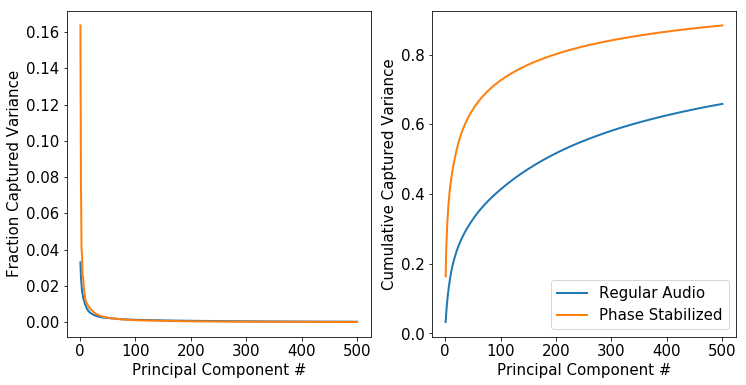

In [16]:
fig, axes = plt.subplots(1, 2)
pc_num = np.arange(1, n_components+1)
axes[0].plot(pc_num, pca_raw.explained_variance_ratio_, label="Regular Audio")
axes[1].plot(pc_num, np.cumsum(pca_raw.explained_variance_ratio_),  label="Regular Audio")
axes[0].plot(pc_num, pca_phstab.explained_variance_ratio_, label="Phase Stabilized")
axes[1].plot(pc_num, np.cumsum(pca_phstab.explained_variance_ratio_), label="Phase Stabilized")
axes[0].set_xlabel("Principal Component #")
axes[1].set_xlabel("Principal Component #")
axes[0].set_ylabel("Fraction Captured Variance")
axes[1].set_ylabel("Cumulative Captured Variance");
plt.legend();

The phase stabilization appears to have done its job. After phase stabilization the audio data lends itself to a linear model like PCA much better than before and we are able to capture much more of the data variation in fewer principal components. I should note that the comparison here is not entirely fair since we are looking at the captured variance as a fraction of total variance in the input data. After phase stabilization the total variance present in the data cloud is somewhat less which makes a direct comparison between the two captured variance curves not entirely straightforward. But as they say the proof of the pudding is in the eating. Does the PCA approximation of the phase stabilized loop sound any better than the PCA approximation of the raw audio we listened to earlier?

In [17]:
reconstruction_phstab_l0 = pca_phstab.inverse_transform(pca_phstab.transform(phase_stabilized[:10]))
save_and_play(
    "phase_stabilized_pca_approx.wav",
    reconstruction_phstab_l0
)

The result doesn't sound great. The PCA approximation has taken us from the poor audio quality of the phase stabilized clips to an even more mangled version. However these approximations are at least good enough that I could pair up the originals and the approximations without difficulty, unlike with the raw pca approximations. Although the audio quality couldn't be described as good the degree of compression is impressive, at just 500 terms this PCA approximation represents a 97% compression rate relative to the 8820 Hz input audio. The compression rate relative to a raw 44.1 KHz CD quality audio signal would be 99.4% 

# Correlation Matrices

Lets take a moment longer to consider exactly why the phase stabilization helps the PCA expansion so much. One way tho think about PCA is as an expansion over the eigenvectors of the covariance matrix of our data. In the current situation our features are sound pressures at 16,000 different points in time. Our covariance matrix will have postive values in it if the pressures at those two points in time tend to vary together and will have a negative value if one tends to decrease as the other tends to increase. By stabilizing the phases of the individual component frequencies in the audio at different times onto a phase standard we have dramatically altered the correlational structure of the data.

## Global Correlation Matrix

The full 16,000x16,000 correlation matrix is too big to really visualize all at once so we will pick a random subset of points to evaluate the correlations at and visualize that for both the regular and phase stabilized audio. We will look at the correlation matrices instead of the covariance matrices in order to adjust for the loss of variance caused by the phase stabilization process. In this particular case the covariance and correlation matrices look extremely similar to each other but the covariance magnitude is slightly less in the case of the phase stabilized data than in the case of the regular audio.

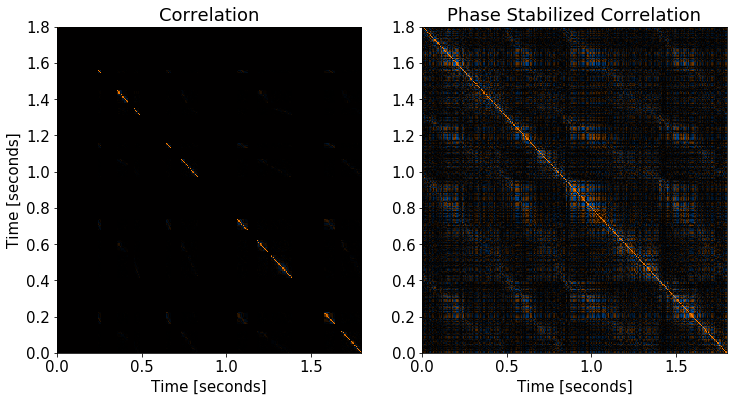

In [18]:
#choose a random subset of time points to evaluate correlations at
targ_indexes = np.unique(np.random.randint(loops.shape[1], size=400))
sub_loops = loops[:, targ_indexes]
sub_loops /= np.std(sub_loops, axis=0)
sub_phstab = phase_stabilized[:, targ_indexes]
sub_phstab /= np.std(sub_phstab, axis=0)
cov_raw = sklearn.covariance.EmpiricalCovariance().fit(sub_loops).covariance_
cov_stabilized = sklearn.covariance.EmpiricalCovariance().fit(sub_phstab).covariance_
    
fig, axes = plt.subplots(1, 2)
extent = [0, 1.8, 0, 1.8]
im_kwargs = dict(vmin=-1, vmax=1, extent=extent, cmap=blue_orange_divergent)
axes[0].imshow(cov_raw, **im_kwargs)
im = axes[1].imshow(cov_stabilized, **im_kwargs)
axes[0].set_title("Correlation")
axes[1].set_title("Phase Stabilized Correlation")
axes[0].set_ylabel("Time [seconds]")
axes[0].set_xlabel("Time [seconds]")
axes[1].set_xlabel("Time [seconds]"); 

Although the rough average beat structure is just visible in the correlation matrix of the raw data (beats tend to occur at 0.0, 0.5, 1.0, and 1.5 seconds there is very little else in terms of visible correlational structure. After phase stabilization the correlation is much richer with many positive and negative correlations occuring over many scales and lots of long range correlations.

## Zoomed in correlations

The fine details in these images are difficult to take in and there is lots of structure at the millisecond scale so it pays to zoom in and take a look at small snippets of data. Looking at just a few milliseconds of data it becomes possible to visualize the individual sound pressures as a line plot and so I have also plotted up the first couple dozen sound clips in each of the zoomed regions along with the corresponding correlation matrix. 

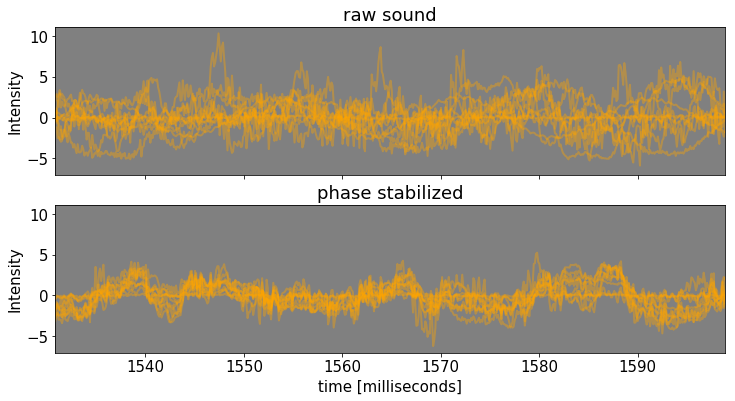

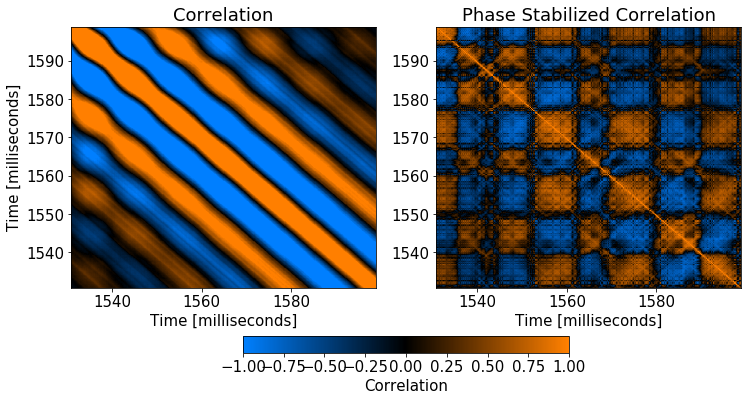

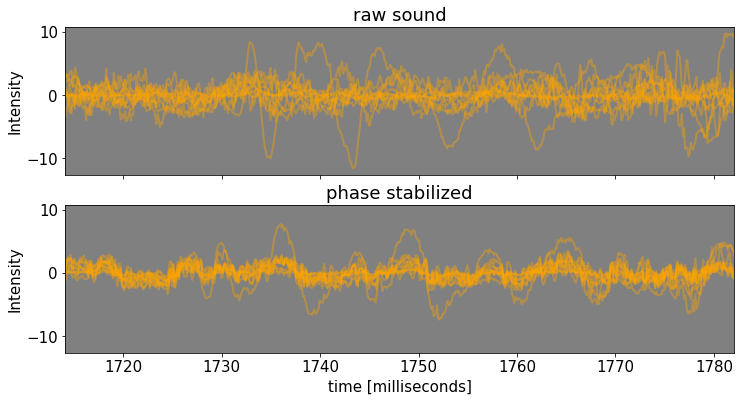

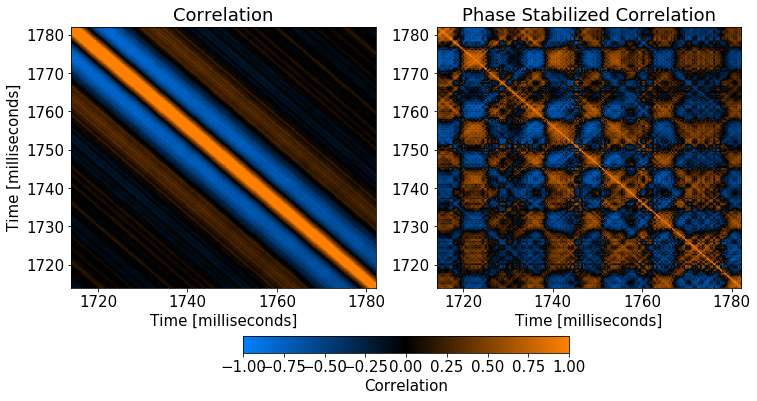

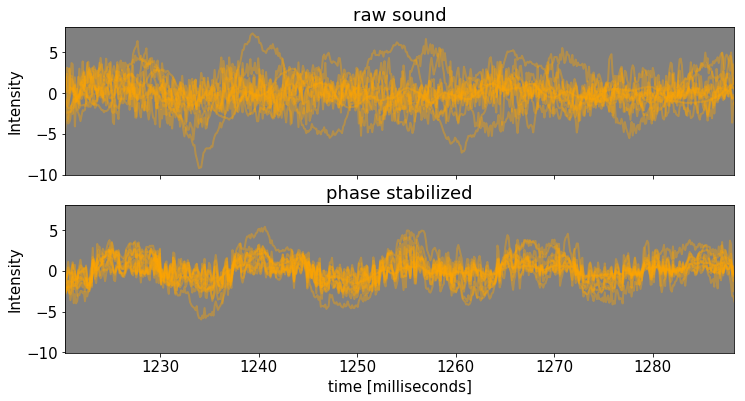

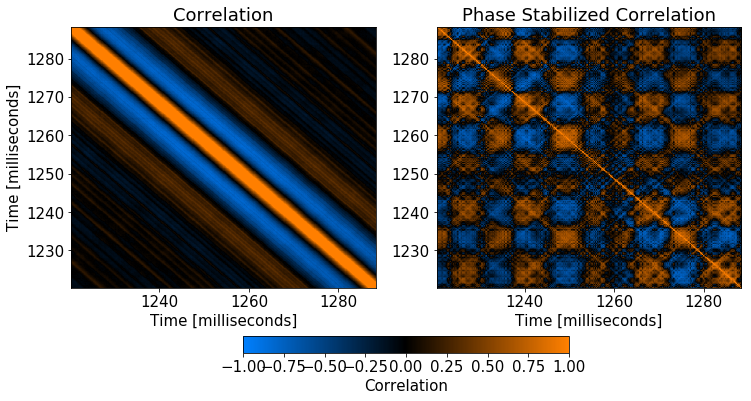

In [19]:
for i in range(3):
    start_index = np.random.randint(16000)
    npts = 600
    delta_t_ms = 1/8.82
    time_range_ms = np.array((start_index, start_index+npts))*delta_t_ms
    clb, cub = start_index, start_index + npts
    
    sub_loops = loops[:, clb:cub]
    sub_loops /= np.std(sub_loops, axis=0)
    sub_phstab = phase_stabilized[:, clb:cub]
    sub_phstab /= np.std(sub_phstab, axis=0)
    
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
    axes[0].set_xlim(*time_range_ms)
    
    for ax in axes:
        ax.patch.set_facecolor("grey")
        ax.set_ylabel("Intensity")
    
    line_kwargs = dict(alpha=0.4, lw=2, color="orange")
    time_ms = np.linspace(*time_range_ms, npts)
    for i in range(10):
        axes[0].plot(time_ms, sub_loops[i], **line_kwargs)
        axes[1].plot(time_ms, sub_phstab[i], **line_kwargs)
    
    axes[0].set_title("raw sound")
    axes[1].set_title("phase stabilized")
    plt.xlabel("time [milliseconds]");
    plt.show()
    
    cov_raw = sklearn.covariance.EmpiricalCovariance().fit(sub_loops).covariance_
    cov_stabilized = sklearn.covariance.EmpiricalCovariance().fit(sub_phstab).covariance_
    
    fig, axes = plt.subplots(1, 2)
    extent = np.hstack([time_range_ms, time_range_ms])
    im_kwargs = dict(vmin=-1, vmax=1, extent=extent, cmap=blue_orange_divergent)
    axes[0].imshow(cov_raw, **im_kwargs)
    im = axes[1].imshow(cov_stabilized, **im_kwargs)
    axes[0].set_title("Correlation")
    axes[1].set_title("Phase Stabilized Correlation")
    axes[0].set_ylabel("Time [milliseconds]")
    axes[0].set_xlabel("Time [milliseconds]")
    axes[1].set_xlabel("Time [milliseconds]")  
    
    cbar = plt.colorbar(im, ax=list(axes), orientation="horizontal", fraction=0.05)
    cbar.set_label("Correlation")
    plt.show()

Looking at the original audio there is no visible relationship between the pressure level high or low at any given moment in time. This is what we would expect since a high magnitue $A_i$ at any frequency could just as easily translate into a large decrement in pressure as it could to a large increase dependent on the phase of the wave. After phase stabilization however increasing the volume of a given frequency component will only ever add to or take away from the pressure at a given time. Increasing the volume of a particular frequency adds pressure intensity to points in time in the same way that an increase of volume at that frequency would in our chosen phase standard.

In the original audio although nearby points in time do show some correlational structure as you move farther away than a few tens of milliseconds the phase cancellation effects wash out the correlation and the covariance drops to near zero. 

## Pure sine covariance

To better understand why the phases of the input data wash out any long range correlations consider a toy example where we are considering a dataset consisting entirely of pure sine waves.
First lets consider the case where all the waves have the same frequency but random phases. The average sound pressure at any point in time is 0 and so the covariance of any two points in time $t_1$ and $t_2$ is the expectation below.

$$
E[y(t_1)y(t_2)] = E_\phi[sin(\omega t_1 + \phi)sin(\omega t_2 + \phi)]
$$

Using the convenient product identity $sin(a)sin(b) = \frac{1}{2}(cos(a-b)-cos(a+b))$ we get the equivalent expectation over phase 

$$
E_\phi[y(t_1)y(t_2)] = E_\phi[cos(\omega(t_1 - t_2)) - cos(2(\omega(t_1+t_2) + \phi))]
$$

At first glance that might seem hard to work out but the second term is the only one that depends on $\phi$ and since the distribution over $\phi$ is uniform and over a span of $2 \pi$ the expectation of the term works out to 0. The first term doesn't have any $\phi$ dependence at all and so the expectation just becomes equal to the value. 

$$
CoV(y(t_1), y(t_2)) = E_\phi[y(t_1)y(t_2)] = \frac{1}{2}cos(\omega(t_1 - t_2))
$$

With this equation in hand we can see that two points will perfectly correlate with each other if they differn in time by $2\pi/\omega$ or any multiple thereof and will perfectly anti-correlate with each other if they differ in time by $\pi/\omega$ or any odd multiple. The sound intensity at two points in time will vary together if they share either the positive lobe or negative lobe of the wave and they will tend to vary in the opposite sense from each other if they are at such a distance that if one populates the positive lobe of the wave that the other one will populate the negative lobe. 

But our sound samples hardly look like sine waves of just one frequency. Even at millisecond time scales there are many different frequencies present at all times. How does the analysis above change if we let frequencies vary randomly as well randomly varying phases? The analysis above is still mostly valid but now we need to take the expectation averaging over frequencies as well as phases. In order to carry out the expectation we would need to assume some sort of distributional form for different frequencies. 

No matter the frequency distribution we choose the phase dependent term will average to zero. The first term on the other hand will always be positive for small enough time differences and will sometimes be positive and sometimes negative for time differences greater than about $1/\omega$. The expectation over frequencies will tend to make these different correlations cancel each other with the cancellation becoming more and more sharp the broader the distribution over frequencies becomes. Exactly what the form of this covariance would is dependent our choice of frequency distribution. Picking a frequency distribution and working out an exact functional form for the covariance isn't important, what is important is the intuition that we can glean from this example.

Random variation in frequency and phase will cause the correlation in sound pressure to be large only for points which are very close in time, on larger time scales differences in frequency and phase force the correlation to zero. If we fix the phase of our waves somehow (e.g. STFT shenanigans) then although the phase independent term still will tend to zero for large time deltas the phase dependent term no longer averages out to zero and will come to dominate the correlation for large time differences. Hopefully this helps to give a better understanding for why the off diagonal (long range) correlation structure in the plots above is large with phase stabilization and effectively 0 without it.

# Eigen-Techno

After going to all that trouble to make sure that our principal vectors are still interpretable as sounds I would be remiss if I didn't play the principal vectors learned by the phase stabilized PCA for comparison with those in the original eigentechno post by Isik.

In [20]:
save_and_play(
    "principal_vectors.wav",
    np.hstack([comp/np.std(comp) for comp in pca_phstab.components_[:20]])
)


The early components sound pretty cool and have lots of diversity with different kinds of beat patterns and sound qualities. I would even say that the first few components stitched together really sounds rather musical and is somewhat pleasant to listen to as well as interesting.

It doesn't take the principal components long to start sounding a little less musical and a lot more like an incoherent jumble. Here are are the components out near the 100th for your listening <strike>dis</strike>pleasure. They sound a bit of a mess.

In [21]:
save_and_play(
    "pca_components_100-105.wav",
    pca_phstab.components_[100:105],
)

# Sampling Random Techno Loops

By treating the PCA transformed data as an uncorrelated Gaussian distribution with RMS widths in each dimension corresponding to the singular values we can use PCA to draw samples from a probability distribution over possible techno loops. What does our PCA model think a typical bit of techno sounds like?

In [22]:
def sample_from_pca_distribution(
    pca, 
    n_samples, 
    n_dims=None,
    space="data",
):
    """Draw samples from a Gaussian probability distribution on the linear subspace learned by a PCA expansion"""
    full_dims = len(pca.explained_variance_)
    #if no dimensionality is given assume we want to use all the dimensions
    if n_dims is None:
        n_dims = len(pca.explained_variance_)
    
    #generate uncorrelated white noise
    noise_sample = np.random.normal(size=(n_samples, full_dims))
    
    #scale the noise to have the appropriate variance in each dimension
    standard_deviations = np.zeros((n_samples, full_dims))
    standard_deviations[:, :n_dims] = np.sqrt(pca.explained_variance_[:n_dims])
    noise_sample *= standard_deviations
    
    if space == "data":
        #transform the noise back into data space
        samples = pca.inverse_transform(noise_sample)
    elif space == "pca":
        samples = noise_sample
    else:
        raise ValueError("space argument invalid")
    
    return samples

In [23]:
save_and_play(
    "pca_distributed_sampled_loops.wav",
    np.hstack([sample/np.std(sample) for sample in sample_from_pca_distribution(pca_phstab, n_samples=10, n_dims=20)])    
)

Some of those loops sound pretty decent while others sound much fainter and more washed out. Although the audio quality isn't fantastic it certainly has the typical beat structure down and there is a fair amount of diversity of sound. But how well can we really capture the probabilistic structure of techno with just a single low dimensional Gaussian? 
Lets take a look at the distribution of our loops in PCA space and see if we can make out any clear structure.

# PCA 2D Marginals

When comparing high dimensional distributions I often find it helpful to compare several different 2D marginal distributions between the observed data and a mock dataset of the same size drawn from a model distribution. If there is no significant difference between the marginal distributions of the mock data set and the observations then that is a good sign that the model distribution is doing a good job (though certainly not sufficient). If the margninal distributions are visually very different from each other you can increase the flexibility of your distributional model a bit at a time until the differences are tolerable. 


In [24]:
projection_ij_pairs = []
for i in range(2):
    for j in range(i+1, 4):
        projection_ij_pairs.append((i, j))

projection_ij_pairs

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3)]

In [25]:
#transform the phase stabilized audio into PCA space
pca_transformed_audio = pca_phstab.transform(phase_stabilized)

#generate a mock data set distributed on the low dimensional subspace learned by PCA
pca_mock = sample_from_pca_distribution(
    pca_phstab, 
    n_samples=len(loops), 
    n_dims=20,
    space="pca",
)

In [26]:
def marginal_density_comparison_plot(
    dimension_pairings,
    data,
    mock_data,
    n_bins,
    count_vmax,
    diff_vmax,
    cutoff_percentile=0.1,
    dimension_prefix="",
):
    fig, axes = plt.subplots(3, len(dimension_pairings))
    for ax in axes.ravel():
        ax.set_xticks([])
        ax.set_yticks([])
    
    for p_idx in range(len(dimension_pairings)):
        x1_idx, x2_idx = dimension_pairings[p_idx]
        axes[0, p_idx].set_title("{} {} vs {}".format(dimension_prefix, x1_idx+1, x2_idx+1), fontsize=14)
 
        min_x, max_x = np.percentile(data[:, x1_idx], [cutoff_percentile, 100-cutoff_percentile])
        min_y, max_y = np.percentile(data[:, x2_idx], [cutoff_percentile, 100-cutoff_percentile])
        x_edge = np.linspace(min_x, max_x, n_bins)
        y_edge = np.linspace(min_y, max_y, n_bins)

        hvals_data = np.histogram2d(data[:, x1_idx], data[:, x2_idx], bins=[x_edge, y_edge])[0]
        hvals_sampled = np.histogram2d(mock_data[:, x1_idx], mock_data[:, x2_idx], bins=[x_edge, y_edge])[0]
        im1 = axes[0, p_idx].imshow(
            hvals_data, 
            origin="lower",
            vmin=0,
            vmax=count_vmax,
        )
        im2 = axes[1, p_idx].imshow(
            hvals_sampled, 
            origin="lower",
            vmin=0,
            vmax=count_vmax,
        )
        diff_im = axes[2, p_idx].imshow(
            hvals_data-hvals_sampled, 
            origin="lower", 
            cmap=blue_orange_divergent,
            vmin=-diff_vmax,
            vmax=diff_vmax,
        )
    
    cbar = plt.colorbar(im1, ax=list(axes[0]))
    cbar.set_label("Counts")
    cbar = plt.colorbar(im2, ax=list(axes[1]))
    cbar.set_label("Counts")
    cbar = plt.colorbar(diff_im, ax=list(axes[2]))
    cbar.set_label("Difference")
    
    axes[0, 0].set_ylabel("Original Data")
    axes[1, 0].set_ylabel("Mock Samples")
    axes[2, 0].set_ylabel("Difference");
    return axes

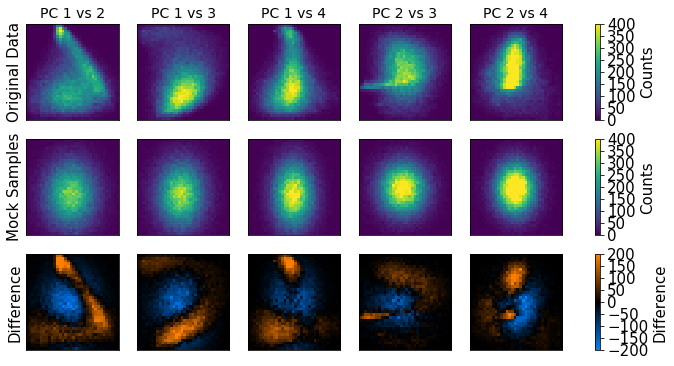

In [27]:
axes = marginal_density_comparison_plot(
    dimension_pairings=projection_ij_pairs,
    data=pca_transformed_audio,
    mock_data=pca_mock,
    n_bins=35,
    count_vmax=400,
    diff_vmax=200,
    dimension_prefix="PC"
)

Clearly just one axis aligned Gaussian bump doesn't do justice to the data distribution. Although PCA manages to capture the rough volume over which the data is distributed there are several features which a single axis aligned Gaussian can't capture. The distribution has at least two clearly different modes and there are apparent tight tracks through PCA space with high over densities. The PCA distribution is a little too diffuse and fails to capture any of the more interesting structure. 

The next step up in complexity from a single Gaussian is to use mixture of several. Convenientely scikit-learn has a nice implementation of fitting such a model for us already implemented and so all we have to do is pick the number of components and number of dimensions to fit the distribution over. The tight tracks in PCA space will show up as regions of with very highly correlated variables and so it is good to use a full indpendent covariance matrix for each component Gaussian. If we keep all 500 dimensions the model will take a lot of memory and a long time to train especially for a large number of component Gaussians. Therefore we keep just the first few dimensions to use for the density model. After a bit of trial and error it seems like a mixture of around 10 components begins to adequately capture the obvious structure in the first few dimensions.

In [28]:
import sklearn.mixture

ndims_gmm = 5
n_components_gmm = 12

gmix = sklearn.mixture.GaussianMixture(
    n_components=n_components_gmm, 
    covariance_type="full",
    reg_covar=0.0001,
    verbose=2, 
)
gmix.fit(pca_transformed_audio[:, :ndims_gmm])

Initialization 0
  Iteration 0	 time lapse 2.05816s	 ll change inf
  Iteration 10	 time lapse 2.32094s	 ll change 0.00197
  Iteration 20	 time lapse 2.33300s	 ll change 0.00102
Initialization converged: True	 time lapse 6.94867s	 ll -20.83115


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=12, n_init=1, precisions_init=None,
        random_state=None, reg_covar=0.0001, tol=0.001, verbose=2,
        verbose_interval=10, warm_start=False, weights_init=None)

Sampling from a mixture of Gaussians is only slightly more complicated than sampling from a Gaussian. We simply need to first appropriately randomize our choice of Gaussian component and then sample as normal.

In [29]:
def gmix_sampler(gmix, n_samples, force_component=None):
    """Sample from a Gaussian mixture model"""
    n_dim = gmix.covariances_.shape[-1]
    n_comp = gmix.n_components
    
    if force_component is None:
        #randomize the choice of components
        interp_coord = np.zeros(n_comp+1)
        interp_coord[1:] = np.cumsum(gmix.weights_)
        interp_coord /= interp_coord[-1]
        interper = scipy.interpolate.interp1d(interp_coord, np.arange(n_comp+1))
        comp_choice = np.floor(interper(np.random.random(n_samples))).astype(int)
    else:
        comp_choice = np.repeat(force_component, n_samples)
    
    samples = np.zeros((n_samples, n_dim), dtype=float)
    
    for ccomp in np.unique(comp_choice):
        mask = comp_choice == ccomp
        n_per = np.sum(mask)
        if gmix.covariance_type == "full":
            samples[mask] = np.random.multivariate_normal(mean=gmix.means_[ccomp], cov=gmix.covariances_[ccomp], size=n_per)
        elif gmix.covariance_type == "diag":
            samples[mask] = mean=gmix.means_[ccomp] + np.random.normal(size=(n_per, n_dim))*np.sqrt(gmix.covariances_[ccomp])
    
    return samples

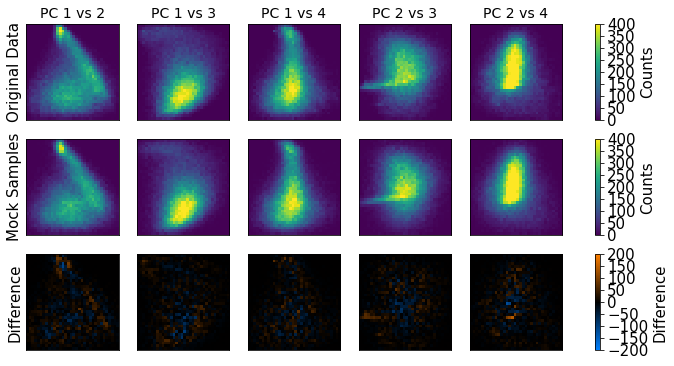

In [30]:
gmm_mock = gmix_sampler(gmix, n_samples=len(loops))

axes = marginal_density_comparison_plot(
    dimension_pairings=projection_ij_pairs,
    data=pca_transformed_audio,
    mock_data=gmm_mock,
    n_bins=35,
    count_vmax=400,
    diff_vmax=200,
    dimension_prefix="PC"
)

The Gaussian mixture does a much better job of capturing the apparent distributional structure in the first few dimensions. Although there is still some clear residual structure in the difference plot the densities look very much alike at first glance.

We can turn samples drawn from the mixture model back into sounds just as in the case of the PCA samples but because we only learned a distribution over the first few dimensions we need to zero-pad the results.

In [31]:
sampled_techno_pc = np.zeros((20, n_components))
sampled_techno_pc[:, :ndims_gmm] = gmix_sampler(gmix, n_samples=20)
gmm_sampled_phstab = pca_phstab.inverse_transform(sampled_techno_pc)

save_and_play(
    "gmm_random_samples.wav",
    np.hstack([sample/np.std(sample) for sample in gmm_sampled_phstab])
)

To my ear the samples drawn from both the rough PCA model and the more distributionally correct mixture model sound very similar. The mixture model samples sound perhaps a little less muffled which I take as a side effect of the mixture model being less diffuse with more probability mass concentrated in the same areas as the data tends to lie.

# Final Thoughts

The phase stabilized PCA worked better than I might have expected given that at the end of the day PCA is just a simple linear model $y = Ax$. For a purely linear model getting rid of the very non-linear effects of phase variation proved to be invaluable. Non-linear could conceivably have enough firepower to deal with phase information without this sort of intervention and may even benefit from leaving the phase variation in the input data. However, I would be willing to bet that some sort of phase standardization would benefit most non-linear models just as much as it benefitted us here. It is important to stress that both the tempo standardization and beat registration done by Isik and the phase stabilization I do here would be necessary to get results like we do here. The phase stabilization works well to help decrease the effects of phase cancellation on millisecond timescales but without also aligning the music on a larger scale in some manner we would still suffer heavily from phase cancellation.

There is a limit to this sort of approach though since with just a purely random phase standard the audio quality of our samples gets degraded rather significantly. It is difficult to know how much useful information has actually been destroyed in the phase standardization process. If our goal is music generation (as opposed to say clustering or genre prediction) then I think it would be foolish to think that we could make a system that could generate samples of any higher apparent audio-quality than what we fed in.

How to best represent audio for input into machine learning algorithms is an open question. Among the most common answers to this question are to use either the magnitudes of the STFT (called a spectrogram) or the <a href=https://en.wikipedia.org/wiki/Mel-frequency_cepstrum >mel-frequency cepstrum </a> which is a transform of the spectrogram which respects the fact that the human ear hears changes in frequency and volume on a log-scale. Both of these approaches throw away phase information entirely and the phase stabilization which we employed here may be seen as a variation on the use of a spectrogram input. 

I'm not entirely happy with the choice of a random phase standard but can't immediately think of any way to do better. I have done some small experiments with using more structured phase standards, for instance the phases of a single triangular or square carrier wave of some frequency. However, if the phase standard has a clear time/frequency structure then that structure is imposed somewhat on the input signals the result of which is a sort of background hum whose character depends on the phase standard being employed. In the case of using a white noise standard we still somewhat suffer from this phase standard induced background noise but it sounds like the hiss, which is altogether more pleasant to my ears than a constant electronic hum.